In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
%matplotlib inline

In [2]:
#图片矢量化
def img2vector(image):
    img=cv2.imread(image,0) #读取图片
    rows,cols=img.shape
    imgVector = np.zeros((1,rows*cols))
    imgVector = np.reshape(img,(1,rows*cols))
    return imgVector

In [7]:
orlpath="ORL"
#读入人脸库,每个人随机选择k张作为训练集,其余构成测试集
def load_orl(k):
    '''
    对训练数据集进行数组初始化，用0填充，每张图片尺寸都定为112*92,
    现在共有40个人，每个人都选择k张，则整个训练集大小为40*k,112*92

    '''
    train_face=np.zeros((40*k,112*92))
    train_label=np.zeros(40*k)#[0,0,.....0](共40*k个0)
    test_face=np.zeros((40*(10-k),112*92))
    test_label=np.zeros(40*(10-k))
    #sample=random.sample(range(10),k)#每个人都有的10张照片中，随机选取k张作为训练样本(10个里面随机选取K个成为一个列表)
    sample=np.random.permutation(10)+1#随机排序1-10 (0-9）+1
    for i in range(40):#共有40个人
        people_num=i+1
        for j in range(10):#每个人都有10张照片
            image=orlpath+'/s'+str(people_num)+'_'+str(sample[j])+'.bmp'
            #读取图片并进行矢量化
            img=img2vector(image)
            if j<k:              
                #构成训练集
                train_face[i*k+j,:] = img
                train_label[i*k+j] =people_num
            else:
                #构成测试集     
                test_face[i*(10-k)+(j-k),:] = img
                test_label[i*(10-k)+(j-k)] = people_num

    return train_face,train_label,test_face,test_label

In [8]:
#定义PCA算法               
def PCA(data,r):
    data=np.float32(np.mat(data))
    rows,cols=np.shape(data)
    data_mean=np.mean(data,0)#对列求平均值
    A=data-np.tile(data_mean,(rows,1))#将所有样例减去对应均值得到A
    C=A*A.T #得到协方差矩阵
    D,V=np.linalg.eig(C)#求协方差矩阵的特征值和特征向量
    V_r=V[:,0:r]#按列取前r个特征向量
    V_r=A.T*V_r#小矩阵特征向量向大矩阵特征向量过渡
    for i in range(r):
        V_r[:,i]=V_r[:,i]/np.linalg.norm(V_r[:,i])#特征向量归一化
    
    final_data=A*V_r
    return final_data,data_mean,V_r

In [9]:
#人脸识别
def face_rec():
    #k=int(input("每个人选择几张照片进行训练："))
    #x_value=[]
    #y_value=[]
    for r in range(10,41,10):
        print("当降维到%d时"%(r))
        x_value=[]
        y_value=[]
        for k in range(1,10):
            train_face,train_label,test_face,test_label=load_orl(k)#得到数据集
        
            #利用PCA算法进行训练
            data_train_new,data_mean,V_r=PCA(train_face,r)
            num_train = data_train_new.shape[0]#训练脸总数
            num_test = test_face.shape[0]#测试脸总数
            temp_face = test_face - np.tile(data_mean,(num_test,1))
            data_test_new = temp_face*V_r #得到测试脸在特征向量下的数据
            data_test_new = np.array(data_test_new) # mat change to array
            data_train_new = np.array(data_train_new)
    
            #测试准确度
            true_num = 0
            for i in range(num_test):
                testFace = data_test_new[i,:]
                diffMat = data_train_new - np.tile(testFace,(num_train,1))#训练数据与测试脸之间距离
                sqDiffMat = diffMat**2
                sqDistances = sqDiffMat.sum(axis=1)#按行求和
                sortedDistIndicies = sqDistances.argsort()#对向量从小到大排序，使用的是索引值,得到一个向量
                indexMin = sortedDistIndicies[0]#距离最近的索引
                if train_label[indexMin] == test_label[i]:
                    true_num += 1
                else:
                    pass

            accuracy = float(true_num)/num_test
            x_value.append(k)
            y_value.append(round(accuracy,2))
            
            print ('当每个人选择%d张照片进行训练时，The classify accuracy is: %.2f%%'%(k,accuracy * 100))
        
        #绘图
        if r==10:
            y1_value=y_value
            plt.plot(x_value,y_value,marker="o",markerfacecolor="red")
            for a, b in zip(x_value, y_value):  
                plt.text(a,b,(a,b),ha='center', va='bottom', fontsize=10)  
 
      
            plt.title("降到10维时识别率",fontsize=14)
            plt.xlabel("K值",fontsize=14)
            plt.ylabel("识别率",fontsize=14)
            plt.show()
            #print ('y1_value',y1_value)
        if r==20:
            y2_value=y_value
            plt.plot(x_value,y2_value,marker="o",markerfacecolor="red")
            for a, b in zip(x_value, y_value):  
                plt.text(a,b,(a,b),ha='center', va='bottom', fontsize=10)  
 
      
            plt.title("降到20维时识别率",fontsize=14)
            plt.xlabel("K值",fontsize=14)
            plt.ylabel("识别率",fontsize=14)
            plt.show() 
            #print ('y2_value',y2_value)
        if r==30:
            y3_value=y_value
            plt.plot(x_value,y3_value,marker="o",markerfacecolor="red")
            for a, b in zip(x_value, y_value):  
                plt.text(a,b,(a,b),ha='center', va='bottom', fontsize=10)  
 
      
            plt.title("降到30维时识别率",fontsize=14)
            plt.xlabel("K值",fontsize=14)
            plt.ylabel("识别率",fontsize=14)
            plt.show()
            #print ('y3_value',y3_value)
        if r==40:
            y4_value=y_value 
            plt.plot(x_value,y4_value,marker="o",markerfacecolor="red")
            for a, b in zip(x_value, y_value):  
                plt.text(a,b,(a,b),ha='center', va='bottom', fontsize=10)  
 
      
            plt.title("降到40维时识别率",fontsize=14)
            plt.xlabel("K值",fontsize=14)
            plt.ylabel("识别率",fontsize=14)
            plt.show()
            #print ('y4_value',y4_value) 
        
        
        
    #各维度下准确度比较
    L1,=plt.plot(x_value,y1_value,marker="o",markerfacecolor="red")   
    L2,=plt.plot(x_value,y2_value,marker="o",markerfacecolor="red")
    L3,=plt.plot(x_value,y3_value,marker="o",markerfacecolor="red")
    L4,=plt.plot(x_value,y4_value,marker="o",markerfacecolor="red")
    #for a, b in zip(x_value, y1_value):  
    #    plt.text(a,b,(a,b),ha='center', va='bottom', fontsize=10)  
 
    plt.legend([L1,L2,L3,L4], ["降到10维", "降到20维","降到30维","降到40维"], loc=4)
    plt.title("各维度识别率比较",fontsize=14)
    plt.xlabel("K值",fontsize=14)
    plt.ylabel("识别率",fontsize=14)
    plt.show()

当降维到10时
当每个人选择1张照片进行训练时，The classify accuracy is: 60.00%
当每个人选择2张照片进行训练时，The classify accuracy is: 71.25%
当每个人选择3张照片进行训练时，The classify accuracy is: 80.71%
当每个人选择4张照片进行训练时，The classify accuracy is: 91.25%
当每个人选择5张照片进行训练时，The classify accuracy is: 87.00%
当每个人选择6张照片进行训练时，The classify accuracy is: 93.75%
当每个人选择7张照片进行训练时，The classify accuracy is: 94.17%
当每个人选择8张照片进行训练时，The classify accuracy is: 96.25%
当每个人选择9张照片进行训练时，The classify accuracy is: 97.50%


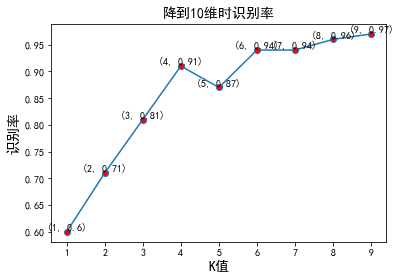

当降维到20时
当每个人选择1张照片进行训练时，The classify accuracy is: 61.67%
当每个人选择2张照片进行训练时，The classify accuracy is: 77.81%
当每个人选择3张照片进行训练时，The classify accuracy is: 86.79%
当每个人选择4张照片进行训练时，The classify accuracy is: 88.33%
当每个人选择5张照片进行训练时，The classify accuracy is: 95.00%
当每个人选择6张照片进行训练时，The classify accuracy is: 96.25%
当每个人选择7张照片进行训练时，The classify accuracy is: 96.67%
当每个人选择8张照片进行训练时，The classify accuracy is: 100.00%
当每个人选择9张照片进行训练时，The classify accuracy is: 97.50%


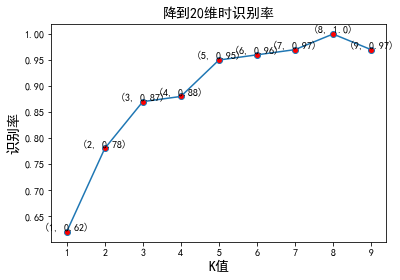

当降维到30时
当每个人选择1张照片进行训练时，The classify accuracy is: 69.72%
当每个人选择2张照片进行训练时，The classify accuracy is: 78.12%
当每个人选择3张照片进行训练时，The classify accuracy is: 87.86%
当每个人选择4张照片进行训练时，The classify accuracy is: 87.92%
当每个人选择5张照片进行训练时，The classify accuracy is: 95.50%
当每个人选择6张照片进行训练时，The classify accuracy is: 95.00%
当每个人选择7张照片进行训练时，The classify accuracy is: 99.17%
当每个人选择8张照片进行训练时，The classify accuracy is: 95.00%
当每个人选择9张照片进行训练时，The classify accuracy is: 97.50%


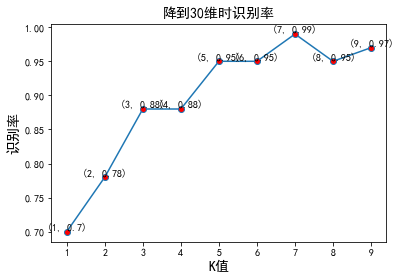

当降维到40时
当每个人选择1张照片进行训练时，The classify accuracy is: 65.00%
当每个人选择2张照片进行训练时，The classify accuracy is: 75.31%
当每个人选择3张照片进行训练时，The classify accuracy is: 87.86%
当每个人选择4张照片进行训练时，The classify accuracy is: 94.58%
当每个人选择5张照片进行训练时，The classify accuracy is: 96.00%
当每个人选择6张照片进行训练时，The classify accuracy is: 97.50%
当每个人选择7张照片进行训练时，The classify accuracy is: 96.67%
当每个人选择8张照片进行训练时，The classify accuracy is: 96.25%
当每个人选择9张照片进行训练时，The classify accuracy is: 97.50%


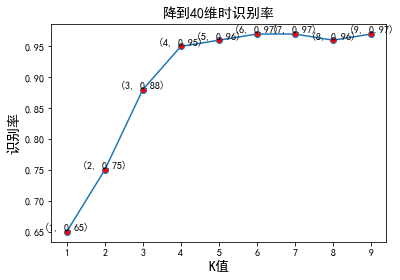

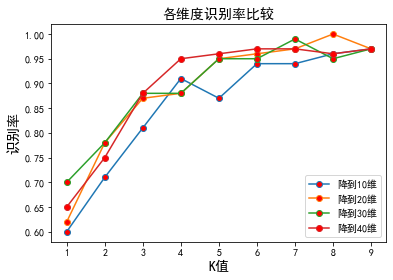

In [10]:
face_rec()